<a href="https://colab.research.google.com/github/saswat0/clipper/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install ipyplot

In [2]:
import glob
import clip
import numpy as np
import requests
import torch
from PIL import Image

In [3]:
def similarity_top(similarity_list,N):
    results = zip(range(len(similarity_list)), similarity_list)
    results = sorted(results, key=lambda x: x[1],reverse= True)
    top_images = []
    scores=[]
    for index,score in results[:N]:
        scores.append(score)
        top_images.append(l[index])
    return scores,top_images

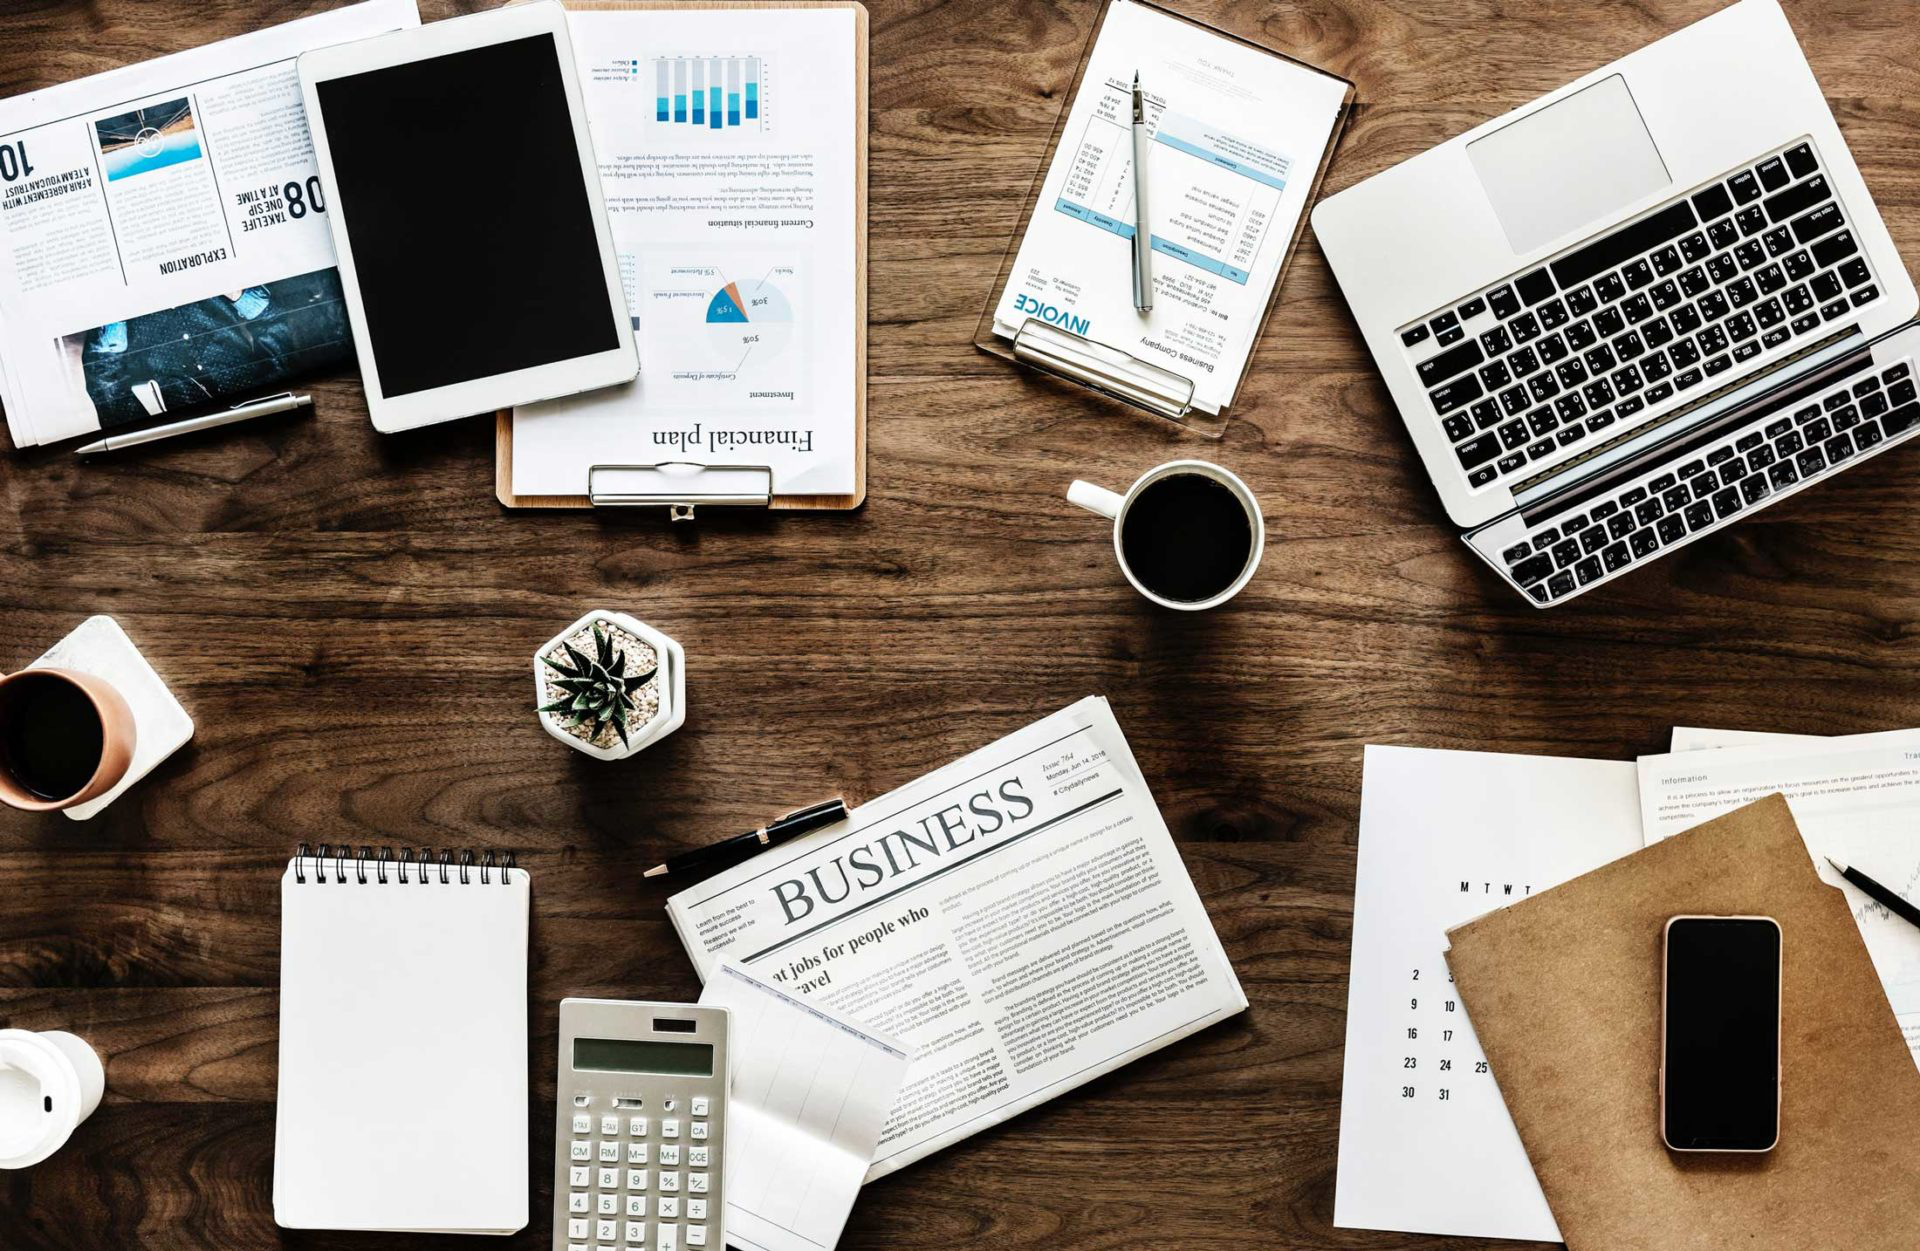

In [4]:
url = 'https://www.truspace.ca/wp-content/uploads/2018/04/employees-from-workplace-1920x1251.jpg'

import requests
import warnings
from io import BytesIO

warnings.filterwarnings("ignore")
import tempfile

response = requests.get(url)
img1 = Image.open(BytesIO(response.content)).convert("RGB")
img1

In [5]:
from IPython.display import Image
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

results = model(img1)
dirpath = tempfile.mkdtemp()
results.crop(save_dir=dirpath)

path= dirpath+'/crops/**/*.jpg'

txtfiles = []

for file in glob.glob(path):
    txtfiles.append(file)

from PIL import Image

l = []
for filename in glob.glob(path):
  foo = Image.open(filename).convert('RGB')
  l.append(foo) 


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

images = torch.stack([preprocess(im) for im in l]).to(device)
with torch.no_grad():
  image_features = model.encode_image(images)
  image_features /= image_features.norm(dim=-1, keepdim=True)

image_features.cpu().numpy()
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

images = [preprocess(im) for im in l]
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-12-23 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Saved 1 image to /tmp/tmpxq6ywl4h
Saved results to /tmp/tmpxq6ywl4h



In [6]:
search_query = "top headlines"


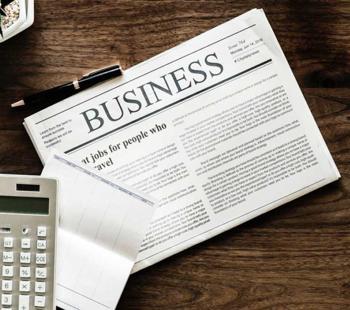


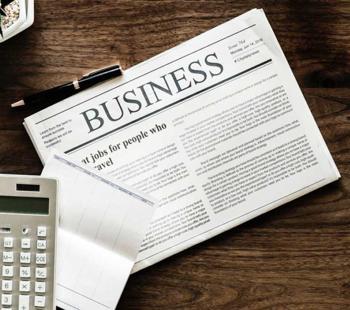

In [8]:
import ipyplot

with torch.no_grad():
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

similarity = text_encoded.cpu().numpy() @ image_features.cpu().numpy().T
similarity = similarity[0]
scores,imgs= similarity_top(similarity,N=1)
ipyplot.plot_images(imgs,img_width=350)